In [1]:
import sys
# sys.path.append('/home/cowvin/Documents/tcc_realestate')

import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns
import pandas.api.types as ptypes
import numpy as np
import optuna
import joblib
from app.api.step import *
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn import ensemble
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, KFold

In [2]:
df_alg = pd.read_csv("../data/joao-pessoa-aluguel.csv")
df1 = pd.read_csv("../data/joao_pessoa.csv").drop(columns=["andar"])
df2 = pd.read_csv("../data/joao_pessoa1.csv") \
    .drop(columns=["z_lat", "z_lon", "bairro_completo",
                   "comercio", "bairro", "zona"]) \
    .transform(lambda x: x.apply(lambda y: float(y)) if ptypes.is_bool_dtype(x) else x)

In [3]:
df3 = pd \
    .read_csv('../data/aluguel_social_jp.csv', delimiter=';') \
    .query('`ANO DO PAGAMENTO` == 2023') \
    .dropna(subset=['BAIRRO']) \
    .rename(columns={'BAIRRO': 'bairro'}) \
    .assign(bairro=lambda x: x.bairro.str.strip().str.title()) \
    .replace(
        {
            r'M[AaNnGg]([a-zA-Z])*\sI': 'Mangabeira I',
            r'M[AaNnGg]([a-zA-Z])*\sII': 'Mangabeira II',
            r'M[AaNnGg]([a-zA-Z])*\sIII': 'Mangabeira III',
            r'M[AaNnGg]([a-zA-Z])*\sIV': 'Mangabeira IV',
            r'M[AaNnGg]([a-zA-Z])*\sVii': 'Mangabeira IV',
            'Mangabeira Iv': 'Mangabeira IV',
            'Mangabeira Iii': 'Mangabeira III',
            'Mangabeira Ii': 'Mangabeira II',
            'Mangabeira Vi': 'Mangabeira VI',
            'Mangabeira Vii': 'Mangabeira VII',
            'Mangabeira Viii': 'Mangabeira VIII',
            'Mangabeira, Viii': 'Mangabeira VIII',
            'Mangabeira 8': 'Mangabeira VIII',
            r'M[AaNnGg]([a-zA-Z])*': 'Mangabeira',
            r'Varad([a-zA-Z]).*': 'Varadouro',
            'Jd Veneza': 'Jardim Veneza',
            'Jd Cidade Universitaria': 'Jardim Cidade Universitaria',
            'Mangabeira \( Aratu\)': 'Mangabeira',
            'Monsenhor Mangabeira': 'Mangabeira',
            'Mangabeira 1': 'Mangabeira',
            'Mangabeira \(Aratu\)': 'Mangabeira',
            'Bairro Dos Estados': 'Estados',
            'Mangabeira 6': 'Mangabeira VI',
            'Cristo': 'Cristo Redentor',
        },
        regex=True
    ) \
    .replace(
        {
            'Monsenhor Mangabeira': 'Mangabeira',
            'Baixo Roger': 'Roger',
            'Funcionarios 2': 'Funcionarios II a IV',
            'Cristo Redentor Redentor': 'Cristo Redentor',
            'Baixo Roger ( Vila Lula\nLucena)': 'Roger',
            'Collinas Do Sul': 'Colinas do Sul',
            'Cidade Verde - Bairro Das Industrias': 'Bairro das Industrias',
            'Cristo Redentor/Vale Das Palmeiras': 'Cristo Redentor',
            'Biarro Das Industria': 'Bairro das Industrias',
            'Altiplano 2': 'Altiplano',
            'Dos Ipes': 'Bairro Dos Ipes',
            'Aeroclube/Bessa': 'Aeroclube',
            'Bairro Sao Jose': 'Sao Jose',
            'B. Industrias': 'Bairro das Industrias',
            'Industrias': 'Bairro das Industrias',
            'B Das Industrias': 'Bairro das Industrias',
            'Funcionarios Ii': 'Funcionarios II a IV',
            'Bela Vista/Cristo Redentor': 'Cristo Redentor',
            'Sao Jose/ Barreira': 'Sao Jose',
            'B. Dos Estados': 'Estados',
            '13 De Mangabeira': 'Mangabeira',
            'Cristro Redentor': 'Cristo Redentor',
            'Funcionario Iii': 'Funcionarios II a IV',
            'Gervasio Mangabeira': 'Mangabeira',
            'Ipes': 'Bairro Dos Ipes',
            'B. Das Industrias': 'Bairro das Industrias',
            'Joao Paulo Ii': 'Joao Paulo II',
            'Padreze': 'Padre Ze',
            'Valentina I': 'Valentina',
            'B. Dos Novais': 'Bairro dos novais',
            'Novais': 'Bairro dos novais',
            'Treze De Mangabeira': 'Mangabeira',
            'Estados': 'Bairro dos estados'
        }
    ) \
    .reset_index(drop=True)
df3 = df3.replace({'Estados': 'bairro dos estados'})

df3 = df3.assign(bairro=lambda x: x.bairro.str.lower().str.replace(' ', '_')) \
    .groupby(['bairro'], as_index=False).size() \
    .rename(columns={'size': 'qnt_beneficio'})

In [4]:
def extract_location(address):
    pattern_joao_pessoa = re.compile(r'(.+),\s*João Pessoa$')
    match_joao_pessoa = pattern_joao_pessoa.search(address)

    if match_joao_pessoa:
        return match_joao_pessoa.group(1).strip()

    pattern_general = re.compile(r',\s*([^,]+)$')
    match_general = pattern_general.search(address)

    if match_general:
        return match_general.group(1).strip()

    return None

def clear_addr(x):
    pattern = re.compile(r'[-,\s]*(.*?)\s*,?\s*João Pessoa - PB')
    extracted_parts = [pattern.search(address).group(1) if pattern.search(address) else None for address in x]

    return [re.sub(r'^.* - ', '', address) for address in extracted_parts]

df1 = df1 \
    .assign(
        bairro=lambda x: clear_addr(x.endereco),
        error=lambda x: list(map(lambda y: ('Rua' in y) or (y == ''), x.bairro.tolist())),
    ) \
    .query('error == False') \
    .reset_index(drop=True) \
    .drop(columns=['error']) \
    .replace(
        {
            'Valentina Figueiredo': 'Valentina de Figueiredo',
            'Jardim Treze de Maio': 'Jardim 13 de Maio'
        }
    )

df2 = df2.assign(bairro=lambda x: [extract_location(address) for address in x.endereco])

df_alg = df_alg \
    .assign(bairro=lambda x: clear_addr(x.endereco)) \
    .replace({
        'Altiplano Cabo Branco': 'Altiplano',
        'ipes': 'Bairro dos Ipes',
        'Estados': 'Bairro dos estados',
        'Jardim Treze de Maio': 'Jardim 13 de Maio',
        'Ipês': 'Bairro dos Ipes'
    })

df_alg = df_alg \
    .assign(
        bairro=lambda x: x.bairro.str.normalize('NFKD') \
            .str.encode('ascii', errors='ignore') \
            .str.decode('utf-8') \
            .str.lower() \
            .str.replace(' ', '_')
    ) \
    .rename(
        columns={
            'area': 'area_aluguel',
            'valor': 'valor_aluguel',
            # 'vaga': 'vaga_aluguel',
            # 'quarto': 'quarto_aluguel',
            # 'banheiro': 'banheiro_aluguel'
            }
        ) \
    .groupby(['bairro'], as_index=False) \
    [['area_aluguel', 'valor_aluguel']] \
    .median()

In [5]:
df = pd.concat([df1, df2]) \
    .drop_duplicates('id') \
    .reset_index(drop=True) \
    .drop(columns=['id', 'url']) \
    .query('bairro != "Monsenhor Magno"') \
    .replace(
        {
            'Altiplano Cabo Branco': 'Altiplano',
            'Estados': 'Bairro dos estados',
            'Ipês': 'Bairro dos ipes',
            'Industrias': 'Bairro das Industrias',
            'Cidade dos Funcionarios II': 'Funcionários II a IV',
            'Cidade dos Colibris': 'Colibris',
            'Conjunto Pedro Gondim': 'Pedro gondim',
            'José Américo de Almeida': 'jose americo'
        }
    )

df = df \
    .assign(bairro=lambda x: x.bairro.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(' ', '_').str.lower()) \
    .merge(df_alg, on='bairro', how='left') \
    .merge(df3, on='bairro', how='left')\
    .reset_index(drop=True)

## Cleaning

In [6]:
def remove_outliers_iqr(data, feature, threshold=1.5):
    df = data.copy()
    q1, q3 = np.percentile(df[feature],  [1, 99])
    iqr = q3 - q1
    upper_bound = q3 + threshold * iqr

    removed_rows = df[df[feature] > upper_bound].index

    if(feature == 'valor'):
        df = df.drop(removed_rows, axis=0)
        return df.query("valor >= 40000").reset_index(drop=True)
    else:
        return df.drop(removed_rows, axis=0).reset_index(drop=True)


In [7]:
df = df.fillna(
    value={
        "academia": 0, "area_servico": 0,
        "elevador": 0, "espaco_gourmet": 0,
        "piscina": 0, "playground": 0,
        "portaria_24_horas": 0, "quadra_de_esporte": 0,
        "salao_de_festa": 0, "sauna": 0,
        "spa": 0, "varanda_gourmet": 0}
    ) \
    .replace(["flat", "terrenos_lotes_condominio"],
             ["flats", "terrenos_lotes_e_condominios"]) \
    .assign(
        latitude_norm=lambda x: (x.latitude - x.latitude.mean()) / x.latitude.std(),
        longitude_norm=lambda x: (x.longitude - x.longitude.mean()) / x.longitude.std(),
    ) \
    .query("-2 < latitude_norm < 2") \
    .query("-2 < longitude_norm < 2") \
    .query("area < 150000 and area >= 20 and valor < 12_000_000 and valor > 40000") \
    .query("tipo not in ['casas_de_vila', 'sobrados', 'coberturas', 'casas_comerciais']") \
    .reset_index(drop=True) \
    .drop(columns=["longitude_norm", "latitude_norm"])

In [8]:
df = remove_outliers_iqr(
    df.assign(
        valor_area = df.valor * df.area
        ),
    "valor_area"
    ) \
    .drop(columns=["valor_area"])

## Train and test dataset

In [9]:
df['valor_cut'] = pd.cut(df['valor'],
    bins=[0.,2e5, 4e5, 6e5, 8e5, np.inf],
    labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df.valor_cut):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]
train_df = train_df.drop(columns=['valor_cut']).reset_index(drop=True)
test_df = test_df.drop(columns=['valor_cut']).reset_index(drop=True)

# df.drop(columns=["valor_cut"]).to_csv("../../data/cleaned/jp_limpo.csv", index=False)
# train_df.to_csv("../../data/cleaned/train.csv", index=False)
# test_df.to_csv("../../data/cleaned/test.csv", index=False)

train_df = train_df.drop(columns=['qnt_beneficio'])
test_df = test_df.drop(columns=['qnt_beneficio'])

## Missing values

In [10]:
# g_missing = sns.displot(
#     data=train_df.isnull() \
#         .melt(value_name="Valores ausentes") \
#         .replace([False, True], ["Não é ausente", "Ausente"]) \
#         .groupby(["variable", "Valores ausentes"]).size() \
#         .reset_index(name="count") \
#         .assign(
#             proportion=lambda x: x.groupby("variable")["count"].transform(lambda y: y / y.sum())
#         ),
#     y="variable",
#     hue="Valores ausentes",
#     weights="proportion",
#     multiple="fill",
#     height=8,
#     aspect=1.1,
#     palette={"Não é ausente": "#f9a602", "Ausente": "gray"}
#     )

# sns.move_legend(obj=g_missing, loc="upper center",
#                 bbox_to_anchor=(.5, -.0001), ncol=2, title="")
# g_missing.set(xlabel="Proporção de valores ausentes (%)", ylabel="")

### Some functions

In [11]:
def display_scores(scores, confidence=0.95):

    print("Scores:", scores)
    print("Média:", scores.mean())
    print("Desvio Padrão:", scores.std())

In [12]:
def plot_error(scores):
    ax, fig = plt.subplots(figsize=(20, 20))
    lineplot = sns.lineplot(y=scores, x=list(range(1, 11)))
    plt.title('Raiz do erro quadrático médio', fontdict={'fontsize': 18})
    plt.xlabel('CV', fontdict={'fontsize': 14})
    plt.ylabel('RMSE', fontdict={'fontsize': 14})
    lineplot.set_xticklabels(lineplot.get_xticklabels(), fontdict={'fontsize': 13})
    lineplot.set_yticklabels(lineplot.get_yticklabels(), fontdict={'fontsize': 13})
    plt.show()

In [13]:
def plot_predict(model):
    plt.figure(figsize=(20, 20))
    scatter = sns.scatterplot(y=np.exp(model.predict(test_df.drop('valor', axis=1))), x=np.exp(test_df.valor) - 1)
    plt.title('Predições VS Valores Reais', fontdict={'fontsize': 18})
    plt.xlabel('Valores Reais', fontdict={'fontsize': 13})
    plt.ylabel('Predições', fontdict={'fontsize': 13})
    plt.show()

In [14]:
gbr_native = ensemble.GradientBoostingRegressor()
lgbm_native = LGBMRegressor(
    # **best_params_lgbm,
    random_state=42)
rf_native = ensemble.RandomForestRegressor()
xgboost_native = XGBRegressor()

## Modeling 

In [15]:
train_df = train_df.assign(valor=lambda x: np.log1p(x.valor))
test_df = test_df.assign(valor=lambda x: np.log1p(x.valor))

In [16]:
drop_cols_fit = ['endereco', 'bairro', 'iptu', 'condominio']

pipe_jp = Pipeline(
    [("imputer", Imputer()),
     ("new_feature", BedAreaBedToi()),
     ("onehot_encoder", OneEncoder()),
     ("yeo", YeoTransform()),
     ("log_transform", LogTransform()),
     ("scaling", Scale()),
    ])
pipe_jp.fit(train_df.drop(columns=drop_cols_fit))

Pipeline(steps=[('imputer', Imputer()), ('new_feature', BedAreaBedToi()),
                ('onehot_encoder', OneEncoder()), ('yeo', YeoTransform()),
                ('log_transform', LogTransform()), ('scaling', Scale())])

In [17]:
# df = df\
#     .assign(
#         id=lambda x: list(range(1, x.shape[0] + 1)),
#         bairro=lambda x: x
#         .bairro
#         .str
#         .replace('_', ' ')
#         .str.upper()
#         .replace(
#             {
#                 'ALTIPLANO': 'ALTIPLANO CABO BRANCO',
#                 'JOSE AMERICO': 'JOSÉ AMÉRICO',
#                 'TAMBAU': 'TAMBAÚ',
#                 'JARDIM CIDADE UNIVERSITARIA': 'JARDIM CIDADE UNIVERSITÁRIA',
#                 'MANAIRA': 'MANAÍRA',
#                 'VARJAO': 'VARJÃO',
#                 'BANCARIOS': 'BANCÁRIOS',
#                 'EXPEDICIONARIOS': 'EXPEDICIONÁRIOS',
#                 'JOAO AGRIPINO': 'JOÃO AGRIPINO',
#                 'MANDACARU': 'MANDACARÚ',
#                 'JARDIM SAO PAULO': 'JARDIM SÃO PAULO',
#                 'COLIBRIS': 'CIDADE DOS COLIBRIS',
#                 'ANATOLIA': 'ANATÓLIA',
#                 'MUCUMAGRO': 'MUÇUMAGRO',
#                 'AGUA FRIA': 'ÁGUA FRIA',
#                 'BAIRRO DOS IPES': 'BAIRRO DOS IPÊS',
#                 'JARDIM LUNA': 'BRISAMAR',
#                 'VALENTINA DE FIGUEIREDO': 'VALENTINA',
#                 'PLANALTO BOA ESPERANCA': 'PLANALTO DA BOA ESPERANÇA',
#                 'CUIA': 'CUIÁ',
#                 'MANGABEIRA IV': 'MANGABEIRA',
#                 'GEISEL': 'ERNESTO GEISEL',
#                 'JOAO PAULO II': 'JOÃO PAULO II',
#                 'TAMBIA': 'TAMBIÁ',
#                 'ALTO DO CEU': 'ALTO DO CÉU',
#                 'QUADRAMARES': 'PORTAL DO SOL',
#                 'CIDADE UNIVERSITARIA': 'JARDIM CIDADE UNIVERSITÁRIA',
#                 'MANGABEIRA VII': 'MANGABEIRA',
#                 'SAO JOSE': 'SÃO JOSÉ',
#                 'JARDIM 13 DE MAIO': 'TREZE DE MAIO',
#                 'PRAIA DO SOL': 'COSTA DO SOL',
#                 'SEIXAS': 'PONTA DO SEIXAS',
#                 'RANGEL': 'VARJÃO',
#                 'COLINAS DO SUL': 'GRAMAME',
#                 'AREA RURAL DE JOAO PESSOA': 'GRAMAME'
#             }
#         ).str.strip()
#     )\
#     .query('bairro not in ["INTERMATES", "PRAIA DE INTERMARES"]')#\
#     # .to_csv("data/cleaned/jp_limpo_bairro_correto2.csv", index=False)

In [18]:
train_df_novo = pipe_jp.transform(train_df.drop(columns=drop_cols_fit))
test_df_novo = pipe_jp.transform(test_df.drop(columns=drop_cols_fit))

In [19]:
train_df_novo = train_df_novo
test_df_novo = test_df_novo

In [20]:
# s = setup(train_df_novo, target='valor')
# best = compare_models()

In [21]:
test_df_clone = test_df.copy()

## Optim

### LGBM

In [67]:
def objective_lgbm(trial):
    num_leaves = trial.suggest_int('num_leaves', 100, 600)
    max_depth = trial.suggest_int('max_depth', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, .01)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    model = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)

In [22]:
# study_lgbm = optuna.create_study(direction="minimize")
# study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=3, show_progress_bar=True)

In [23]:
# joblib.dump(study_lgbm, "study_pkl/study_lgbm_new_var.pkl")

In [73]:
best_params_lgbm_novas_variaveis = {
    'num_leaves': 202,
    'max_depth': 379,
    'learning_rate': 0.009857215099413444,
    'n_estimators': 1988}

best_params_lgbm = {
    'num_leaves': 247,
    'max_depth': 299,
    'learning_rate': 0.009035568789398086,
    'n_estimators': 1798}

In [80]:
lgbm = LGBMRegressor(
    **best_params_lgbm_novas_variaveis,
    random_state=42,
    n_jobs=1)

In [81]:
lgbm.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2262
[LightGBM] [Info] Number of data points in the train set: 25424, number of used features: 30
[LightGBM] [Info] Start training from score 13.051175


LGBMRegressor(learning_rate=0.009857215099413444, max_depth=379,
              n_estimators=1988, n_jobs=1, num_leaves=202, random_state=42)

In [88]:
study_lgbm.best_value

0.2854629296236018

In [82]:
lgbm.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

0.8725794650754604

In [83]:
preds_lgbm = lgbm.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_lgbm'] = preds_lgbm

In [84]:
print(mean_absolute_percentage_error(test_df_clone.valor, preds_lgbm))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_lgbm)))

0.013400556235097673
0.2838503933614798


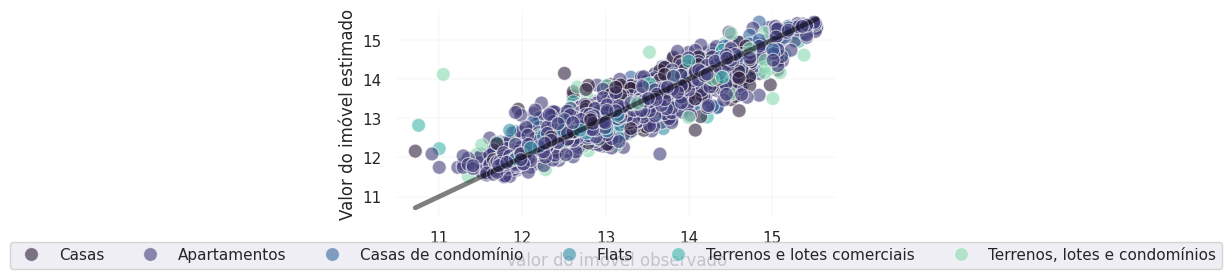

In [102]:
fig = plt.Figure(figsize=(5.7, 2.7))

plot = sns.scatterplot(
    # data=test_df_clone\
    # .assign(
    #     nivel=lambda x: (x.academia + x.espaco_gourmet + x.quadra_de_esporte +
    #      x.sauna + x.varanda_gourmet + x.playground).astype(object)
    # ),
    data=test_df_clone,
    x='valor',
    y='preds_lgbm',
    s=100,
    # style='nivel',
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds_lgbm'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds_lgbm'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

# sns.set_theme(rc={'figure.figsize': (5.7, 2.7)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
# plt.savefig("../../tcc_escrita/includes/lgbm_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#joblib.dump(study_lgbm, 'study_pkl/study_lgbm.pkl')

### Random Forest

In [80]:
forest = ensemble.RandomForestRegressor(
    n_estimators=650,
    random_state=42,
    max_depth=22,
    max_features="sqrt",
    n_jobs=1)

In [ ]:
forest.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)

In [ ]:
forest.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

In [117]:
preds = forest.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds'] = preds

In [ ]:
print(np.expm1(mean_absolute_error(test_df_clone.valor, preds)))
print(mean_absolute_percentage_error(test_df_clone.valor, preds))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds)))

In [ ]:
fig = plt.Figure(figsize=(20, 10))

plot = sns.scatterplot(
    data=test_df_clone,
    x='valor',
    y='preds',
    s=100,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

sns.set_theme(rc={'figure.figsize': (20, 10)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
# plt.savefig("../../tcc_escrita/includes/rf_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [103]:
def objective_rf(trial):
    params = dict(
        n_estimators=trial.suggest_int(name='n_estimators', low=1, high=2000),
        max_depth=trial.suggest_int(name='max_depth', low=20, high=1000),
        max_features='sqrt',
        random_state=42
    )

    model = ensemble.RandomForestRegressor(
        **params
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop("valor", axis=1),
        y=train_df_novo.valor,
        scoring="neg_mean_squared_error",
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)

In [ ]:
# joblib.dump(study, 'study_pkl/study_rf.pkl')

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_rf, n_trials=100, show_progress_bar=True, n_jobs=-1)

[I 2025-03-08 09:50:14,584] A new study created in memory with name: no-name-1d313f67-5f7a-4c43-b6e6-36cf0677584b


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
plot = optuna.visualization.plot_param_importances(study)
plot.update_layout(
    title="",
    xaxis_title="Importância dos Hiperparâmetros",
    yaxis_title="Hiperparâmetros"
)

## Gradient boosting

In [24]:
def objective_gbr(trial):
    learning_rate = trial.suggest_float(name='learning_rate', low=0.1e-4, high=0.1)
    n_estimators = trial.suggest_int(name='n_estimators', low=50, high=1500)
    max_depth = trial.suggest_int(name='max_depth', low=3, high=500)
    max_features = 'sqrt'


    model = ensemble.GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        max_features=max_features,
    )
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [21]:
# study_gdr = optuna.create_study(direction='minimize')
# study_gdr.optimize(objective_gbr, n_trials=100, show_progress_bar=True)

In [103]:
best_params_gdt = {
    'learning_rate': 0.08730488291054857,
    'n_estimators': 1500,
    'max_depth': 6
    }

gdt = ensemble.GradientBoostingRegressor(
    **best_params_gdt,
    random_state=42,
    max_features="sqrt")

In [ ]:
gdt.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)
gdt.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

In [113]:
preds_gdt = gdt.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_gdt'] = preds_gdt

In [ ]:
print(np.expm1(mean_absolute_error(test_df_clone.valor, preds_gdt)))
print(mean_absolute_percentage_error(test_df_clone.valor, preds_gdt))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_gdt)))

In [ ]:
fig = plt.Figure(figsize=(20, 20))

plot = sns.scatterplot(
    data=test_df_clone,
    x='valor',
    y='preds_gdt',
    s=100,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds_gdt'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds_gdt'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

sns.set_theme(rc={'figure.figsize': (20, 10)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("../../tcc_escrita/includes/gdt_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
joblib.dump(study_gdr, "study_pkl/study_gdt.pkl")

### XGBoost

In [ ]:
def objective_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-7, 0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 200),
        'random_state': 42
    }

    model = XGBRegressor(**params)
    model.fit(X=train_df_novo.drop('valor', axis=1), y=train_df_novo.valor)

    cv_scores = np.expm1(np.sqrt(-cross_val_score(
        estimator=model,
        X=train_df_novo.drop('valor', axis=1),
        y=train_df_novo.valor,
        scoring='neg_mean_squared_error',
        cv=KFold(n_splits=20))))

    return np.mean(cv_scores)


In [23]:
best_params_xgb = {
    'n_estimators': 788,
    'learning_rate': 0.07119699155402735,
    'max_depth': 8}

xgb = XGBRegressor(
    **best_params_xgb,
    random_state=42)

In [ ]:
xgb.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)
xgb.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

In [98]:
preds_xgb = xgb.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_xgb'] = preds_xgb

In [ ]:
print(np.expm1(mean_absolute_error(test_df_clone.valor, preds_xgb)))
print(mean_absolute_percentage_error(test_df_clone.valor, preds_xgb))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_xgb)))

In [ ]:
fig = plt.Figure(figsize=(20, 20))

plot = sns.scatterplot(
    data=test_df_clone,
    x='valor',
    y='preds_xgb',
    s=100,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds_xgb'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds_xgb'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

sns.set_theme(rc={'figure.figsize': (20, 10)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("../../tcc_escrita/includes/xgb_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgboost, n_trials=100, n_jobs=3)

[I 2025-03-08 10:00:23,375] A new study created in memory with name: no-name-590f8d37-5f15-45b9-a772-f0f6e3de046e
[I 2025-03-08 10:03:27,236] Trial 1 finished with value: 0.33234631772061984 and parameters: {'n_estimators': 377, 'learning_rate': 0.45926481212327636, 'max_depth': 119}. Best is trial 1 with value: 0.33234631772061984.
[I 2025-03-08 10:03:38,572] Trial 0 finished with value: 0.33123242526268976 and parameters: {'n_estimators': 552, 'learning_rate': 0.4539592901269064, 'max_depth': 193}. Best is trial 0 with value: 0.33123242526268976.
[I 2025-03-08 10:04:19,382] Trial 2 finished with value: 0.33151041396017106 and parameters: {'n_estimators': 1272, 'learning_rate': 0.4606796563851999, 'max_depth': 145}. Best is trial 0 with value: 0.33123242526268976.
[I 2025-03-08 10:08:55,953] Trial 5 finished with value: 0.33097407659734934 and parameters: {'n_estimators': 1313, 'learning_rate': 0.4467400905216806, 'max_depth': 138}. Best is trial 5 with value: 0.33097407659734934.
[I 

In [ ]:
# joblib.dump(study_xgb, 'study_pkl/study_xgb.pkl')

## Stacking

In [23]:
estimators = [
    ('xgb', XGBRegressor(**best_params_xgb, random_state=42)),
    ('rf', ensemble.RandomForestRegressor(
        n_estimators=650,
        random_state=42,
        max_depth=22,
        max_features="sqrt",
        n_jobs=1
    )),
    ('lgbm', LGBMRegressor(**best_params_lgbm, random_state=42, n_jobs=1)),
    ('gdt', ensemble.GradientBoostingRegressor(
        **best_params_gdt,
        random_state=42,
        max_features="sqrt"
    ))
]

stacking = ensemble.StackingRegressor(
    estimators=estimators,
    final_estimator=ensemble.RandomForestRegressor(
        n_estimators=650,
        random_state=42,
        max_depth=22,
        max_features="sqrt",
        n_jobs=1
    ),
    verbose=2,
    n_jobs=3
)

In [ ]:
stacking.fit(X=train_df_novo.drop(columns=['valor']), y=train_df_novo.valor)
# stacking.score(X=test_df_novo.drop(columns=['valor']), y=test_df_novo.valor)

In [29]:
preds_stacking = stacking.predict(X=test_df_novo.drop(columns=['valor']))
test_df_clone['preds_stacking'] = preds_stacking

In [ ]:
print(np.expm1(mean_absolute_error(test_df_clone.valor, preds_stacking)))
print(mean_absolute_percentage_error(test_df_clone.valor, preds_stacking))
print(np.expm1(root_mean_squared_error(test_df_clone.valor, preds_stacking)))

In [ ]:
fig = plt.Figure(figsize=(20, 20))

plot = sns.scatterplot(
    data=test_df_clone,
    x='valor',
    y='preds_stacking',
    s=100,
    hue='tipo',
    palette='mako',
    alpha=.6)

min_val = min(test_df_clone['valor'].min(), test_df_clone['preds_stacking'].min())
max_val = max(test_df_clone['valor'].max(), test_df_clone['preds_stacking'].max())
plot.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="black",
    linewidth=3.5,
    alpha=.5
    )

plot.grid(True, color='grey', linewidth=.05)
plot.set_facecolor('white')
plot.spines['top'].set_visible(True)
plot.spines['right'].set_visible(True)
plot.spines['left'].set_visible(True)
plot.spines['bottom'].set_visible(True)

sns.set_theme(rc={'figure.figsize': (20, 10)})
plot.set_xlabel('Valor do imóvel observado')
plot.set_ylabel('Valor do imóvel estimado')

l = plt.legend(loc="upper center", bbox_to_anchor=(.5, -.08), ncol=7)
l.get_texts()[0].set_text('Casas')
l.get_texts()[1].set_text('Apartamentos')
l.get_texts()[2].set_text('Casas de condomínio')
l.get_texts()[3].set_text('Flats')
l.get_texts()[4].set_text('Terrenos e lotes comerciais')
l.get_texts()[5].set_text('Terrenos, lotes e condomínios')
plt.savefig("../../tcc_escrita/includes/stacking_plot_predict.svg", dpi=600, bbox_inches='tight')
plt.show()

In [29]:
# from sklearn.inspection import partial_dependence

# X = test_df_novo.drop(columns=['valor'])
# features = X.columns.tolist()
# cat_features = [
#     'encoder__tipo_apartamentos', 'encoder__tipo_casas',
#     'encoder__tipo_casas_de_condominio', 'encoder__tipo_flats',
#     'encoder__tipo_terrenos_e_lotes_comerciais', 'encoder__tipo_terrenos_lotes_e_condominios',
#     'vertical_horizontal', 'varanda_gourmet', 'spa', 'sauna', 'salao_de_festa',
#     'portaria_24_horas', 'quadra_de_esporte', 'playground', 'piscina', 'espaco_gourmet',
#     'elevador', 'academia'
# ]
# num_features = np.array(features)[~X.columns.isin(cat_features)].tolist()

# pdp = partial_dependence(
#     stacking,
#     features=num_features,
#     # categorical_features=cat_features,
#     kind='both',
#     X=X)

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

X = test_df_novo.drop(columns=['valor'])
features = X.columns.tolist()
cat_features = [
    'encoder__tipo_apartamentos', 'encoder__tipo_casas',
    'encoder__tipo_casas_de_condominio', 'encoder__tipo_flats',
    'encoder__tipo_terrenos_e_lotes_comerciais', 'encoder__tipo_terrenos_lotes_e_condominios',
    'vertical_horizontal', 'varanda_gourmet', 'spa', 'sauna', 'salao_de_festa',
    'portaria_24_horas', 'quadra_de_esporte', 'playground', 'piscina', 'espaco_gourmet',
    'elevador', 'academia', 'area_servico'
]
num_features = np.array(features)[~X.columns.isin(cat_features + ["total_comodo"])].tolist()

ice_pdp = PartialDependenceDisplay\
    .from_estimator(
        stacking,
        X,
        num_features,
        kind='both',
        centered=True,
        random_state=42
    )

fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(15, 15)

In [ ]:
fig

In [ ]:
from matplotlib.lines import Line2D

new_xlabels = ["Área", "Banheiro", "Quarto", "Vaga", "Latitude", "Longitude", "Área de aluguel", "Valor de aluguel"]


for idx, (ax1, xlabel) in enumerate(zip(ice_pdp.axes_.ravel(), new_xlabels)):
    if ax1 is not None:
        for line in ax1.get_lines()[:-1]:
            line.set_color('#00708d')
            line.set_alpha(0.4)

        pdp_line = ax1.get_lines()[-1]
        pdp_line.set_color('orange')
        pdp_line.set_linewidth(2.5)

        if ax1.get_legend() is not None:
            ax1.get_legend().remove()

        ax1.set_xlabel(xlabel, fontsize=13)

        if idx % 3 == 0:
            ax1.set_ylabel("Dependência parcial", fontsize=13)
        ax1.grid(True, which="major", axis="both", linestyle="-", color="lightgray", linewidth=0.8, alpha=0.9)
        ax1.grid(True, which="minor", axis="both", linestyle=":", color="lightgray", linewidth=0.5, alpha=0.8)

legend_line = Line2D([0], [0], color='orange', linestyle="--", linewidth=2.5, label="Média")
fig.legend(
    handles=[legend_line],
    loc="lower center",
    fontsize=13,
    ncol=1,
    bbox_to_anchor=(0.5, 0.02),
)

fig.tight_layout(rect=[0, 0.05, 1, 1])


In [162]:
fig.savefig("../../tcc_escrita/includes/pdp_ice.svg", dpi=600, bbox_inches="tight")

In [ ]:
import shap

X1000 = shap.utils.sample(train_df_novo.drop(columns="valor"), 1000)

explainer_stacking = shap.Explainer(stacking.predict, X1000)
shap_values_stacking = explainer_stacking(
    test_df_novo.drop(columns="valor")
)

In [165]:
shap_values = joblib.load('study_pkl/shap_values.pkl')

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

custom_cmap = matplotlib.colormaps["viridis"]

selected_features = test_df_novo.loc[:, test_df_novo.columns.isin(["area", "banheiro", "quarto", "vaga", "latitude", "longitude", "area_aluguel", "valor_aluguel"])].columns.tolist()
filtered_df = test_df_novo[selected_features]

filtered_shap_values = shap_values[:, [1, 3, 10, 14, 16, 17, 18, 19]]

shap.summary_plot(
    filtered_shap_values,
    filtered_df,
    plot_type="dot",
    show=False,
    cmap=custom_cmap,
    plot_size=(10, 5)
)
feature_names = [
    "Área de aluguel", "Quarto", "Banheiro",
    "Latitude", "Valor de aluguel",
    "Longitude", "Vaga", "Área"
]

fig, ax = plt.gcf(), plt.gca()

ax.set_yticklabels(feature_names, fontsize=12)
colorbar = fig.axes[-1]
colorbar.set_ylabel("Valor da variável", fontsize=13)
colorbar.set_yticklabels(["Baixo", "Alto"])
ax.grid(True, which="major", axis="both", linestyle="-", color="lightgray", linewidth=0.8, alpha=0.9)
ax.grid(True, which="minor", axis="both", linestyle=":", color="lightgray", linewidth=0.5, alpha=0.8)

ax.set_axisbelow(True)

ax.set_xlabel("Valor SHAP (impacto na predição do modelo)", fontsize=13)

plt.savefig("../../tcc_escrita/includes/shap_summary_plot.svg", dpi=600, bbox_inches="tight")

In [ ]:
selected_features = test_df_novo.loc[:, test_df_novo.columns.isin([
    "academia", "area", "area_servico",
    "banheiro", "elevador", "espaco_gourmet",
    "piscina", "playground", "portaria_24_horas",
    "quadra_de_esporte", "quarto", "salao_de_festa",
    "sauna", "spa", "vaga", "varanda_gourmet", "latitude", "longitude",
    "area_aluguel", "valor_aluguel"])].columns.tolist()
filtered_df = test_df_novo[selected_features]

filtered_shap_values = shap_values[:, 0:20]

shap.summary_plot(
    filtered_shap_values,
    filtered_df,
    plot_type="bar",
    color="#00708d",
    show=False,
    plot_size=(10, 5))

fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel("Média(|Valor SHAP|) (impacto médio na magnitude da predição do modelo)", fontsize=13)

feature_names=[
    "Área", "Vaga", "Longitude",
    "Valor de aluguel", "Latitude",
    "Banheiro", "Academia", "Quarto",
    "Área de aluguel", "Elevador",
    "Piscina", "Espaço gourmet",
    "Varanda gourmet", "Área  de serviço",
    "Salão de festa", "Playground",
    "Spa", "Sauna", "Portaria 24 horas",
    "Quadra de esporte"
    ]
ax.set_yticklabels(feature_names[::-1], fontsize=12)
ax.grid(True, which="major", axis="both", linestyle="-", color="lightgray", linewidth=0.8, alpha=0.9)
ax.grid(True, which="minor", axis="both", linestyle=":", color="lightgray", linewidth=0.5, alpha=0.8)

ax.set_axisbelow(True)

plt.savefig("../../tcc_escrita/includes/shap_importance.svg", dpi=600, bbox_inches="tight")

In [307]:
def dep_plot(var, label):
    shap.dependence_plot(
        var,
        shap_values.values,
        test_df_novo.drop(columns="valor").values,
        feature_names=test_df_novo.drop(columns="valor").columns,
        alpha=.7,
        dot_size=16,
        show=False,
        color="#00708d",
        interaction_index=None,
        )
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 5)

    ax.set_xlabel(label, fontsize=13)
    ax.set_ylabel(f"Valores SHAP para\n{label}", fontsize=13)
    ax.grid(True, which="major", axis="both", linestyle="-", color="lightgray", linewidth=0.8, alpha=0.9)
    ax.grid(True, which="minor", axis="both", linestyle=":", color="lightgray", linewidth=0.5, alpha=0.8)
    plt.savefig(f"../../tcc_escrita/includes/dependence_plot_cat/dep_plot_{var}.svg", dpi=600, bbox_inches="tight")

In [ ]:
dep_plot("elevador", "Elevador")